# Train LSTM

## Import libraries

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import optuna
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import shap
import pickle

## Import data

In [2]:
sts = pd.read_csv('/Users/suhrudp/Library/CloudStorage/OneDrive-Personal/Stats/REMAP Open Dataset PD/Analysis/merged_sts_data.csv')

In [3]:
sts = sts.dropna(subset=['sts_whole_episode_duration'])
sts = sts.dropna(subset=['PD_or_C'])
sts = sts[sts['DBS_state'] != "On DBS"]

In [4]:
sts.columns

Index(['Unnamed: 0', 'Transition ID', 'Participant ID number', 'PD_or_C',
       'sts_whole_episode_duration', 'sts_final_attempt_duration',
       'On_or_Off_medication', 'DBS_state', 'Clinical_assessment',
       'STS_additional_features', 'MDS-UPDRS_score_3.9 _arising_from_chair',
       'frame_number', 'time_s', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7',
       'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17',
       'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'y1', 'y2',
       'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11', 'y12', 'y13',
       'y14', 'y15', 'y16', 'y17', 'y18', 'y19', 'y20', 'y21', 'y22', 'y23',
       'y24', 'y25'],
      dtype='object')

## Preprocess the data

In [5]:
features = [f'x{i}' for i in range(1, 26)] + [f'y{i}' for i in range(1, 26)] + ['sts_whole_episode_duration']

sts.sort_values(['Participant ID number', 'time_s'], inplace=True)

sts['DBS_state'] = sts['DBS_state'].astype('category').cat.codes

scaler = RobustScaler()
sts[features] = scaler.fit_transform(sts[features])

sts['PD_or_C'] = sts['PD_or_C'].astype('category').cat.codes

ovs = SMOTE(random_state=73)
X = sts[features + ['Participant ID number']].values
y = sts['PD_or_C'].values
X_adasyn, y_adasyn = ovs.fit_resample(X, y)

sts_adasyn = pd.DataFrame(X_adasyn, columns=features + ['Participant ID number'])
sts_adasyn['PD_or_C'] = y_adasyn

train_data, temp_data = train_test_split(sts_adasyn, test_size=0.25, random_state=73, stratify=sts_adasyn['PD_or_C'])
val_data, test_data = train_test_split(temp_data, test_size=0.4, random_state=73, stratify=temp_data['PD_or_C'])

print(f'Train data: {len(train_data)} samples')
print(f'Validation data: {len(val_data)} samples')
print(f'Test data: {len(test_data)} samples')


Train data: 111928 samples
Validation data: 22386 samples
Test data: 14924 samples


In [ ]:
#scaler_filename = 'scaler_sts.pkl'
#with open(scaler_filename, 'wb') as file:
#    pickle.dump(scaler, file)
#print(f'Scaler saved as {scaler_filename}')

## Create a dataset class for sequences

In [6]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, sequence_length=150):
        self.seq_length = sequence_length
        self.data = dataframe
        self.features = features
        self.patient_ids = dataframe['Participant ID number'].values

    def __len__(self):
        return len(self.data) // self.seq_length

    def __getitem__(self, index):
        start_idx = index * self.seq_length
        end_idx = start_idx + self.seq_length
        sequences = self.data.iloc[start_idx:end_idx][self.features].values
        label = self.data.iloc[start_idx:end_idx]['PD_or_C'].values[-1]
        patient_id = self.patient_ids[start_idx]
        return torch.tensor(sequences, dtype=torch.float32), torch.tensor(label, dtype=torch.long), torch.tensor(patient_id, dtype=torch.long)
    
train_dataset = SequenceDataset(train_data, sequence_length=15)
val_dataset = SequenceDataset(val_data, sequence_length=15)
test_dataset = SequenceDataset(test_data, sequence_length=15)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Define the LSTM model

In [7]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_patients, output_dim=2, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        
        self.patient_embedding = nn.Embedding(num_patients, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, patient_ids):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        out = out[:, -1, :]
        
        patient_intercepts = self.patient_embedding(patient_ids)
        out = out + patient_intercepts
        
        out = self.fc(out)
        return out

## Model training and evaluation

In [8]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')
num_patients = len(sts['Participant ID number'].unique())

model = LSTMClassifier(input_dim=len(features), hidden_dim=100, num_patients=num_patients, output_dim=2, num_layers=1).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, criterion, optimizer, train_loader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for sequences, labels, patient_ids in train_loader:
            sequences, labels, patient_ids = sequences.to(device), labels.to(device), patient_ids.to(device)
            optimizer.zero_grad()
            outputs = model(sequences, patient_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}')

def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for sequences, labels, patient_ids in test_loader:
            sequences, labels, patient_ids = sequences.to(device), labels.to(device), patient_ids.to(device)
            outputs = model(sequences, patient_ids)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total:.2f}%')

train_model(model, criterion, optimizer, train_loader, num_epochs=10)
evaluate_model(model, val_loader)

Using device: mps
Epoch 1/10, Loss: 0.6354
Epoch 2/10, Loss: 0.5722
Epoch 3/10, Loss: 0.5389
Epoch 4/10, Loss: 0.4985
Epoch 5/10, Loss: 0.4565
Epoch 6/10, Loss: 0.4099
Epoch 7/10, Loss: 0.3549
Epoch 8/10, Loss: 0.2951
Epoch 9/10, Loss: 0.2283
Epoch 10/10, Loss: 0.1805
Accuracy: 72.25%


## Tune hyperparameters

In [9]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

num_patients = len(sts['Participant ID number'].unique())

def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 50, 200)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    model = LSTMClassifier(input_dim=len(features), hidden_dim=hidden_dim, num_patients=num_patients, output_dim=2, num_layers=num_layers).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model.train()
    for epoch in range(10):
        for sequences, labels, patient_ids in train_loader:
            sequences, labels, patient_ids = sequences.to(device), labels.to(device), patient_ids.to(device)
            optimizer.zero_grad()
            outputs = model(sequences, patient_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for sequences, labels, patient_ids in val_loader:
            sequences, labels, patient_ids = sequences.to(device), labels.to(device), patient_ids.to(device)
            outputs = model(sequences, patient_ids)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-08-16 00:26:17,496] A new study created in memory with name: no-name-9b07144d-b3ea-4e0a-a990-eff66d641a08


Using device: mps


[I 2024-08-16 00:26:42,829] Trial 0 finished with value: 0.7050938337801609 and parameters: {'hidden_dim': 71, 'num_layers': 1, 'lr': 0.0002550031176883342, 'batch_size': 16}. Best is trial 0 with value: 0.7050938337801609.
[I 2024-08-16 00:27:08,699] Trial 1 finished with value: 0.7004021447721179 and parameters: {'hidden_dim': 198, 'num_layers': 1, 'lr': 0.0001063847300505526, 'batch_size': 16}. Best is trial 0 with value: 0.7050938337801609.
[I 2024-08-16 00:27:22,024] Trial 2 finished with value: 0.6836461126005362 and parameters: {'hidden_dim': 140, 'num_layers': 1, 'lr': 0.00055680814476372, 'batch_size': 64}. Best is trial 0 with value: 0.7050938337801609.
[I 2024-08-16 00:27:47,522] Trial 3 finished with value: 0.7117962466487936 and parameters: {'hidden_dim': 102, 'num_layers': 1, 'lr': 0.0019187159675202279, 'batch_size': 16}. Best is trial 3 with value: 0.7117962466487936.
[I 2024-08-16 00:28:12,244] Trial 4 finished with value: 0.7084450402144772 and parameters: {'hidden_di

Best trial:
  Value: 0.7546916890080428
  Params: 
    hidden_dim: 51
    num_layers: 2
    lr: 0.0038146932746655686
    batch_size: 32


## Train model on new hyperparameters and on the test set

In [20]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_patients = len(sts['Participant ID number'].unique())

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

model = LSTMClassifier(input_dim=len(features), hidden_dim=51, num_patients=num_patients, output_dim=2, num_layers=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0038)

def train_model(model, criterion, optimizer, train_loader, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for sequences, labels, patient_ids in train_loader:
            sequences, labels, patient_ids = sequences.to(device), labels.to(device), patient_ids.to(device)
            optimizer.zero_grad()
            outputs = model(sequences, patient_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}')

def evaluate_model(model, val_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for sequences, labels, patient_ids in val_loader:
            sequences, labels, patient_ids = sequences.to(device), labels.to(device), patient_ids.to(device)
            outputs = model(sequences, patient_ids)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    tn, fp, fn, tp = confusion_matrix(all_labels, all_predictions).ravel()
    
    specificity = tn / (tn + fp)
    npv = tn / (tn + fn) if (tn + fn) != 0 else 0

    print(f'Confusion Matrix:\nTN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')
    print(f'Accuracy: {accuracy:.3f}')
    print(f'Precision (PPV): {precision:.3f}')
    print(f'Negative Predictive Value (NPV): {npv:.3f}')
    print(f'Recall (Sensitivity): {recall:.3f}')
    print(f'Specificity: {specificity:.3f}')
    print(f'F1 Score: {f1:.3f}')

train_model(model, criterion, optimizer, train_loader, num_epochs=20)
evaluate_model(model, val_loader)

Using device: mps
Epoch 1/20, Loss: 0.6377
Epoch 2/20, Loss: 0.5867
Epoch 3/20, Loss: 0.5474
Epoch 4/20, Loss: 0.5067
Epoch 5/20, Loss: 0.4593
Epoch 6/20, Loss: 0.4083
Epoch 7/20, Loss: 0.3752
Epoch 8/20, Loss: 0.3335
Epoch 9/20, Loss: 0.2981
Epoch 10/20, Loss: 0.2618
Epoch 11/20, Loss: 0.2302
Epoch 12/20, Loss: 0.1987
Epoch 13/20, Loss: 0.1608
Epoch 14/20, Loss: 0.1479
Epoch 15/20, Loss: 0.1246
Epoch 16/20, Loss: 0.1151
Epoch 17/20, Loss: 0.0942
Epoch 18/20, Loss: 0.0951
Epoch 19/20, Loss: 0.0745
Epoch 20/20, Loss: 0.0593
Confusion Matrix:
TN: 544, FP: 215, FN: 205, TP: 528
Accuracy: 0.718
Precision (PPV): 0.711
Negative Predictive Value (NPV): 0.726
Recall (Sensitivity): 0.720
Specificity: 0.717
F1 Score: 0.715


In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_patients = len(sts['Participant ID number'].unique())

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

model = LSTMClassifier(input_dim=len(features), hidden_dim=51, num_patients=num_patients, output_dim=2, num_layers=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0038)

def train_model(model, criterion, optimizer, train_loader, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for sequences, labels, patient_ids in train_loader:
            sequences, labels, patient_ids = sequences.to(device), labels.to(device), patient_ids.to(device)
            optimizer.zero_grad()
            outputs = model(sequences, patient_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}')

def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for sequences, labels, patient_ids in test_loader:
            sequences, labels, patient_ids = sequences.to(device), labels.to(device), patient_ids.to(device)
            outputs = model(sequences, patient_ids)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
 
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    tn, fp, fn, tp = confusion_matrix(all_labels, all_predictions).ravel()
    
    specificity = tn / (tn + fp)
    npv = tn / (tn + fn) if (tn + fn) != 0 else 0

    print(f'Confusion Matrix:\nTN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')
    print(f'Accuracy: {accuracy:.3f}')
    print(f'Precision (PPV): {precision:.3f}')
    print(f'Negative Predictive Value (NPV): {npv:.3f}')
    print(f'Recall (Sensitivity): {recall:.3f}')
    print(f'Specificity: {specificity:.3f}')
    print(f'F1 Score: {f1:.3f}')

train_model(model, criterion, optimizer, train_loader, num_epochs=20)
evaluate_model(model, test_loader)

Using device: mps
Epoch 1/20, Loss: 0.6454
Epoch 2/20, Loss: 0.5855
Epoch 3/20, Loss: 0.5351
Epoch 4/20, Loss: 0.4842
Epoch 5/20, Loss: 0.4434
Epoch 6/20, Loss: 0.4050
Epoch 7/20, Loss: 0.3557
Epoch 8/20, Loss: 0.3247
Epoch 9/20, Loss: 0.2882
Epoch 10/20, Loss: 0.2595
Epoch 11/20, Loss: 0.2132
Epoch 12/20, Loss: 0.1758
Epoch 13/20, Loss: 0.1724
Epoch 14/20, Loss: 0.1242
Epoch 15/20, Loss: 0.1163
Epoch 16/20, Loss: 0.1267
Epoch 17/20, Loss: 0.0959
Epoch 18/20, Loss: 0.0816
Epoch 19/20, Loss: 0.0552
Epoch 20/20, Loss: 0.0605
Confusion Matrix:
TN: 347, FP: 158, FN: 119, TP: 370
Accuracy: 0.721
Precision (PPV): 0.701
Negative Predictive Value (NPV): 0.745
Recall (Sensitivity): 0.757
Specificity: 0.687
F1 Score: 0.728


In [11]:
def bootstrap_sample(model, test_loader, indices):
    boot_predictions = []
    boot_labels = []
    
    for i in indices:
        sequences, labels, patient_ids = test_loader.dataset[i]
        
        sequences = sequences.unsqueeze(0).to(device)
        labels = torch.tensor([labels]).to(device)
        patient_ids = torch.tensor([patient_ids]).to(device)

        outputs = model(sequences, patient_ids)
        _, predicted = torch.max(outputs.data, 1)
        boot_predictions.extend(predicted.cpu().numpy())
        boot_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(boot_labels, boot_predictions)
    precision = precision_score(boot_labels, boot_predictions, zero_division=0)
    recall = recall_score(boot_labels, boot_predictions)
    f1 = f1_score(boot_labels, boot_predictions)
    tn, fp, fn, tp = confusion_matrix(boot_labels, boot_predictions).ravel()
    
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    npv = tn / (tn + fn) if (tn + fn) != 0 else 0

    return accuracy, precision, recall, f1, specificity, npv

def bootstrap_metrics_parallel_joblib(model, test_loader, n_bootstraps=2000, n_jobs=-1):
    dataset_size = len(test_loader.dataset)
    
    results = Parallel(n_jobs=n_jobs)(delayed(bootstrap_sample)(model, test_loader, np.random.randint(0, dataset_size, dataset_size)) for _ in range(n_bootstraps))

    all_metrics = {
        "accuracy": [result[0] for result in results],
        "precision": [result[1] for result in results],
        "recall": [result[2] for result in results],
        "f1": [result[3] for result in results],
        "specificity": [result[4] for result in results],
        "npv": [result[5] for result in results],
    }
    
    mean_metrics = {metric: np.mean(values) for metric, values in all_metrics.items()}
    std_error_metrics = {metric: np.std(values) for metric, values in all_metrics.items()}

    ci_metrics = {
        metric: (
            np.percentile(values, 2.5),
            np.percentile(values, 97.5)
        )
        for metric, values in all_metrics.items()
    }

    return mean_metrics, std_error_metrics, ci_metrics

def evaluate_model_with_parallel_ci_joblib(model, test_loader, n_bootstraps=2000, n_jobs=-1):
    model.eval()

    mean_metrics, std_error_metrics, ci_metrics = bootstrap_metrics_parallel_joblib(model, test_loader, n_bootstraps, n_jobs)

    print(f'Mean Accuracy: {mean_metrics["accuracy"]:.3f} (SE: {std_error_metrics["accuracy"]:.3f}, 95% CI: {ci_metrics["accuracy"][0]:.3f}-{ci_metrics["accuracy"][1]:.3f})')
    print(f'Mean Precision (PPV): {mean_metrics["precision"]:.3f} (SE: {std_error_metrics["precision"]:.3f}, 95% CI: {ci_metrics["precision"][0]:.3f}-{ci_metrics["precision"][1]:.3f})')
    print(f'Mean Recall (Sensitivity): {mean_metrics["recall"]:.3f} (SE: {std_error_metrics["recall"]:.3f}, 95% CI: {ci_metrics["recall"][0]:.3f}-{ci_metrics["recall"][1]:.3f})')
    print(f'Mean F1 Score: {mean_metrics["f1"]:.3f} (SE: {std_error_metrics["f1"]:.3f}, 95% CI: {ci_metrics["f1"][0]:.3f}-{ci_metrics["f1"][1]:.3f})')
    print(f'Mean Specificity: {mean_metrics["specificity"]:.3f} (SE: {std_error_metrics["specificity"]:.3f}, 95% CI: {ci_metrics["specificity"][0]:.3f}-{ci_metrics["specificity"][1]:.3f})')
    print(f'Mean Negative Predictive Value (NPV): {mean_metrics["npv"]:.3f} (SE: {std_error_metrics["npv"]:.3f}, 95% CI: {ci_metrics["npv"][0]:-.3f}-{ci_metrics["npv"][1]:.3f})')

evaluate_model_with_parallel_ci_joblib(model, test_loader, n_bootstraps=2000, n_jobs=-1)

Mean Accuracy: 0.721 (SE: 0.014, 95% CI: 0.693-0.748)
Mean Precision (PPV): 0.701 (SE: 0.020, 95% CI: 0.663-0.739)
Mean Recall (Sensitivity): 0.757 (SE: 0.019, 95% CI: 0.718-0.795)
Mean F1 Score: 0.727 (SE: 0.016, 95% CI: 0.695-0.757)
Mean Specificity: 0.687 (SE: 0.021, 95% CI: 0.645-0.726)
Mean Negative Predictive Value (NPV): 0.744 (SE: 0.020, 95% CI: 0.705-0.786)


In [28]:
def evaluate_model_with_roc(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for sequences, labels, patient_ids in test_loader:
            sequences, labels, patient_ids = sequences.to(device), labels.to(device), patient_ids.to(device)
            outputs = model(sequences, patient_ids)
            probabilities = torch.softmax(outputs, dim=1)[:, 1]
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    tn, fp, fn, tp = confusion_matrix(all_labels, all_predictions).ravel()
    
    specificity = tn / (tn + fp)
    npv = tn / (tn + fn) if (tn + fn) != 0 else 0

    print(f'Confusion Matrix:\nTN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')
    print(f'Accuracy: {accuracy:.3f}')
    print(f'Precision (PPV): {precision:.3f}')
    print(f'Negative Predictive Value (NPV): {npv:.3f}')
    print(f'Recall (Sensitivity): {recall:.3f}')
    print(f'Specificity: {specificity:.3f}')
    print(f'F1 Score: {f1:.3f}')

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12, 12))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve for Sit-to-Stand Data')
    plt.legend(loc='lower right')

    plt.savefig("roc_curve_sts.png", dpi=600)
    plt.close()

train_model(model, criterion, optimizer, train_loader, num_epochs=20)
evaluate_model_with_roc(model, test_loader)

Epoch 1/20, Loss: 0.0000
Epoch 2/20, Loss: 0.0000
Epoch 3/20, Loss: 0.0000
Epoch 4/20, Loss: 0.0000
Epoch 5/20, Loss: 0.0000
Epoch 6/20, Loss: 0.0000
Epoch 7/20, Loss: 0.0000
Epoch 8/20, Loss: 0.0000
Epoch 9/20, Loss: 0.0000
Epoch 10/20, Loss: 0.0000
Epoch 11/20, Loss: 0.0000
Epoch 12/20, Loss: 0.0000
Epoch 13/20, Loss: 0.0000
Epoch 14/20, Loss: 0.0000
Epoch 15/20, Loss: 0.0000
Epoch 16/20, Loss: 0.0000
Epoch 17/20, Loss: 0.0000
Epoch 18/20, Loss: 0.0000
Epoch 19/20, Loss: 0.0000
Epoch 20/20, Loss: 0.0000
Confusion Matrix:
TN: 372, FP: 133, FN: 95, TP: 394
Accuracy: 0.771
Precision (PPV): 0.748
Negative Predictive Value (NPV): 0.797
Recall (Sensitivity): 0.806
Specificity: 0.737
F1 Score: 0.776


In [34]:
#model_filename = 'model_sts.pth'
#torch.save(model.state_dict(), model_filename)
#print(f'Model saved as {model_filename}')

Model saved as model_sts.pth


In [29]:
def bootstrap_sample(model, test_loader, indices):
    boot_predictions = []
    boot_labels = []
    
    for i in indices:
        sequences, labels, patient_ids = test_loader.dataset[i]
        
        sequences = sequences.unsqueeze(0).to(device)
        labels = torch.tensor([labels]).to(device)
        patient_ids = torch.tensor([patient_ids]).to(device)

        outputs = model(sequences, patient_ids)
        _, predicted = torch.max(outputs.data, 1)
        boot_predictions.extend(predicted.cpu().numpy())
        boot_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(boot_labels, boot_predictions)
    precision = precision_score(boot_labels, boot_predictions, zero_division=0)
    recall = recall_score(boot_labels, boot_predictions)
    f1 = f1_score(boot_labels, boot_predictions)
    tn, fp, fn, tp = confusion_matrix(boot_labels, boot_predictions).ravel()
    
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    npv = tn / (tn + fn) if (tn + fn) != 0 else 0

    return accuracy, precision, recall, f1, specificity, npv

def bootstrap_metrics_parallel_joblib(model, test_loader, n_bootstraps=2000, n_jobs=-1):
    dataset_size = len(test_loader.dataset)
    
    results = Parallel(n_jobs=n_jobs)(delayed(bootstrap_sample)(model, test_loader, np.random.randint(0, dataset_size, dataset_size)) for _ in range(n_bootstraps))

    all_metrics = {
        "accuracy": [result[0] for result in results],
        "precision": [result[1] for result in results],
        "recall": [result[2] for result in results],
        "f1": [result[3] for result in results],
        "specificity": [result[4] for result in results],
        "npv": [result[5] for result in results],
    }
    
    mean_metrics = {metric: np.mean(values) for metric, values in all_metrics.items()}
    std_error_metrics = {metric: np.std(values) for metric, values in all_metrics.items()}

    ci_metrics = {
        metric: (
            np.percentile(values, 2.5),
            np.percentile(values, 97.5)
        )
        for metric, values in all_metrics.items()
    }

    return mean_metrics, std_error_metrics, ci_metrics

def evaluate_model_with_parallel_ci_joblib(model, test_loader, n_bootstraps=2000, n_jobs=-1):
    model.eval()

    mean_metrics, std_error_metrics, ci_metrics = bootstrap_metrics_parallel_joblib(model, test_loader, n_bootstraps, n_jobs)

    print(f'Mean Accuracy: {mean_metrics["accuracy"]:.3f} (SE: {std_error_metrics["accuracy"]:.3f}, 95% CI: {ci_metrics["accuracy"][0]:.3f}-{ci_metrics["accuracy"][1]:.3f})')
    print(f'Mean Precision (PPV): {mean_metrics["precision"]:.3f} (SE: {sstd_error_metrics["precision"]:.3f}, 95% CI: {ci_metrics["precision"][0]:.3f}-{ci_metrics["precision"][1]:.3f})')
    print(f'Mean Recall (Sensitivity): {mean_metrics["recall"]:.3f} (SE: {std_error_metrics["recall"]:.3f}, 95% CI: {ci_metrics["recall"][0]:.3f}-{ci_metrics["recall"][1]:.3f})')
    print(f'Mean F1 Score: {mean_metrics["f1"]:.3f} (SE: {std_error_metrics["f1"]:.3f}, 95% CI: {ci_metrics["f1"][0]:.3f}-{ci_metrics["f1"][1]:.3f})')
    print(f'Mean Specificity: {mean_metrics["specificity"]:.3f} (SE: {std_error_metrics["specificity"]:.3f}, 95% CI: {ci_metrics["specificity"][0]:.3f}-{ci_metrics["specificity"][1]:.3f})')
    print(f'Mean Negative Predictive Value (NPV): {mean_metrics["npv"]:.3f} (SE: {std_error_metrics["npv"]:.3f}, 95% CI: {ci_metrics["npv"][0]:-.3f}-{ci_metrics["npv"][1]:.3f})')

evaluate_model_with_parallel_ci_joblib(model, test_loader, n_bootstraps=2000, n_jobs=-1)

/Users/suhrudp/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mean Accuracy: 0.770 (SE: 0.013, 95% CI: 0.743-0.795)
Mean Precision (PPV): 0.747 (SE: 0.019, 95% CI: 0.710-0.783)
Mean Recall (Sensitivity): 0.805 (SE: 0.018, 95% CI: 0.769-0.839)
Mean F1 Score: 0.775 (SE: 0.014, 95% CI: 0.747-0.802)
Mean Specificity: 0.736 (SE: 0.019, 95% CI: 0.698-0.774)
Mean Negative Predictive Value (NPV): 0.796 (SE: 0.019, 95% CI: 0.758-0.831)


## Using SHAP to explain model predictions

In [12]:
background = train_data.sample(100)[features].values 

def model_predict(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float32).to(device) 
    model.eval()
    with torch.no_grad():
        sequences = inputs.view(inputs.shape[0], -1, len(features))
        patient_ids = torch.zeros(inputs.shape[0], dtype=torch.int64).to(device)
        outputs = model(sequences, patient_ids)
        probabilities = nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy()
explainer = shap.KernelExplainer(model_predict, background)

test_sample = test_data.sample(10)[features].values

shap_values = explainer.shap_values(test_sample)

shap.initjs()

# for class 1
shap.force_plot(explainer.expected_value[1], shap_values[0][:, 1], test_sample[0], feature_names=features)

  0%|          | 0/10 [00:00<?, ?it/s]

In [13]:
background = train_data.sample(100)[features].values 

def model_predict(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float32).to(device) 
    model.eval()
    with torch.no_grad():
        sequences = inputs.view(inputs.shape[0], -1, len(features))
        patient_ids = torch.zeros(inputs.shape[0], dtype=torch.int64).to(device)
        outputs = model(sequences, patient_ids)
        probabilities = nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy()
explainer = shap.KernelExplainer(model_predict, background)

explainer = shap.KernelExplainer(model_predict, background)

test_sample = test_data.sample(10)[features].values

shap_values = explainer.shap_values(test_sample)

shap.initjs()

# for class 0
shap.force_plot(explainer.expected_value[0], shap_values[0][:, 0], test_sample[0], feature_names=features)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

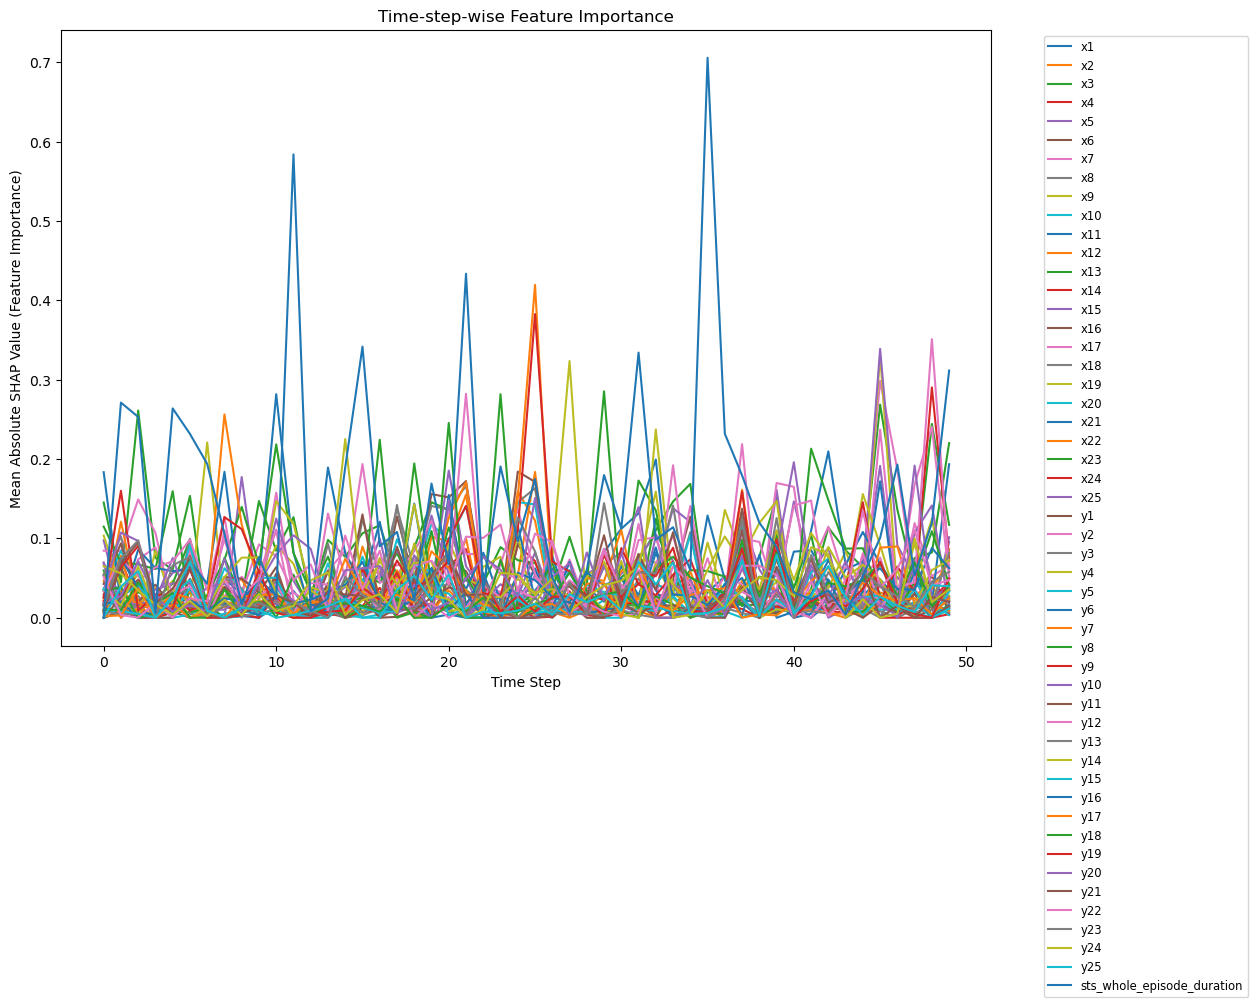

In [14]:
def model_predict(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
    inputs = inputs.unsqueeze(1)
    model.eval()
    with torch.no_grad():
        patient_ids = torch.zeros(inputs.shape[0], dtype=torch.int64).to(device)
        outputs = model(inputs, patient_ids)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy()

shap_sample = train_data.sample(100, random_state=73)
shap_sample_features = shap_sample[features].values.reshape(-1, 50, len(features))

num_sequences = 10
num_time_steps = 50
test_sample = test_data.sample(num_sequences * num_time_steps, random_state=73)[features].values
test_sample = test_sample.reshape(num_sequences, num_time_steps, len(features))

shap_values_all_time_steps = np.zeros((test_sample.shape[1], test_sample.shape[2]))

for t in range(test_sample.shape[1]):
    test_sample_timestep = test_sample[:, t, :]
    shap_sample_timestep = shap_sample_features[:, t, :]

    explainer = shap.KernelExplainer(model_predict, shap_sample_timestep)

    shap_values_timestep = explainer.shap_values(test_sample_timestep)
    
    shap_values_mean = np.mean(np.abs(shap_values_timestep[0]), axis=1)
    
    shap_values_all_time_steps[t, :] = shap_values_mean

plt.figure(figsize=(12, 8))
for i, feature_name in enumerate(features):
    plt.plot(range(test_sample.shape[1]), shap_values_all_time_steps[:, i], label=feature_name)

plt.xlabel('Time Step')
plt.ylabel('Mean Absolute SHAP Value (Feature Importance)')
plt.title('Time-step-wise Feature Importance')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()

In [32]:
plt.figure(figsize=(12, 8))
for i, feature_name in enumerate(features):
    plt.plot(range(test_sample.shape[1]), shap_values_all_time_steps[:, i], label=feature_name)

plt.xlabel('Time Step')
plt.ylabel('Mean Absolute SHAP Value (Feature Importance)')
plt.title('Time-step-wise Feature Importance')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.savefig("shap_feature_importance_icon.png", bbox_inches='tight', dpi=600)
plt.close()

In [15]:
def model_predict(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
    inputs = inputs.unsqueeze(1)
    model.eval()
    with torch.no_grad():
        patient_ids = torch.zeros(inputs.shape[0], dtype=torch.int64).to(device)
        outputs = model(inputs, patient_ids)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy()

shap_sample = train_data.sample(500, random_state=73)
shap_sample_features = shap_sample[features].values.reshape(-1, 500, len(features))

num_sequences = 10
num_time_steps = 500
test_sample = test_data.sample(num_sequences * num_time_steps, random_state=73)[features].values
test_sample = test_sample.reshape(num_sequences, num_time_steps, len(features))

shap_values_all_time_steps = np.zeros((test_sample.shape[1], test_sample.shape[2]))

for t in range(test_sample.shape[1]):
    test_sample_timestep = test_sample[:, t, :]
    shap_sample_timestep = shap_sample_features[:, t, :]

    explainer = shap.KernelExplainer(model_predict, shap_sample_timestep)

    shap_values_timestep = explainer.shap_values(test_sample_timestep)
    
    shap_values_mean = np.mean(np.abs(shap_values_timestep[0]), axis=1)
    
    shap_values_all_time_steps[t, :] = shap_values_mean

plt.style.use('ggplot')

plt.figure(figsize=(40, 8))
for i, feature_name in enumerate(features):
    plt.plot(range(test_sample.shape[1]), shap_values_all_time_steps[:, i], label=feature_name)

plt.xticks(ticks=np.arange(0, num_time_steps + 1, step=15))

plt.xlabel('Time Step')
plt.ylabel('Mean Absolute SHAP Value (Feature Importance)')
plt.title('Time-step-wise Feature Importance')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.savefig("shap_feature_importance_sts.png", dpi=600, bbox_inches='tight')
plt.close()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/suhrudp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/Users/suhrudp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/suhrudp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2261: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
/Users/suhrudp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:2262: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

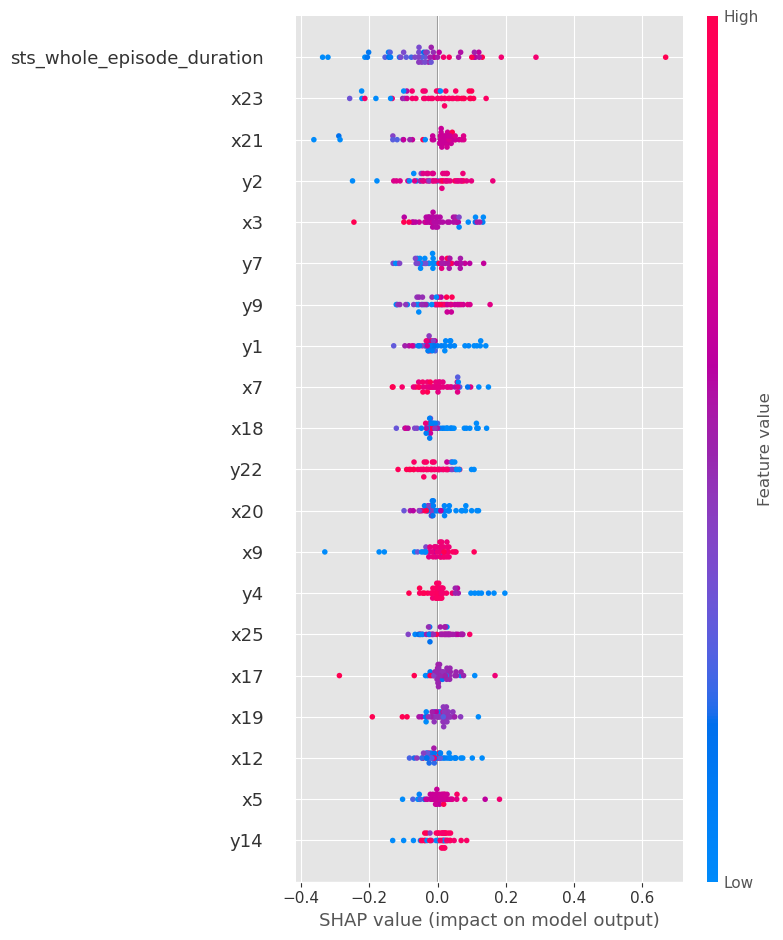

In [16]:
def model_predict(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float32).to(device) 
    model.eval()
    with torch.no_grad():
        sequences = inputs.view(inputs.shape[0], -1, len(features))
        patient_ids = torch.zeros(inputs.shape[0], dtype=torch.int64).to(device)
        outputs = model(sequences, patient_ids)
        probabilities = nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy()

shap_sample = train_data.sample(50, random_state=73)
shap_sample_features = shap_sample[features].values

explainer = shap.KernelExplainer(model_predict, background)
shap_values = explainer.shap_values(shap_sample_features)

shap_values_class_1 = shap_values[:, :, 1]

shap.summary_plot(shap_values_class_1, shap_sample_features, feature_names=features)

In [17]:
plt.style.use('ggplot')

shap_sample = train_data.sample(1000, random_state=73)
shap_sample_features = shap_sample[features].values

explainer = shap.KernelExplainer(model_predict, background)
shap_values = explainer.shap_values(shap_sample_features)

shap_values_class_1 = shap_values[:, :, 1]

plt.figure()

shap.summary_plot(shap_values_class_1, shap_sample_features, feature_names=features, show=False)

plt.savefig("shap_summary_plot_sts.png", bbox_inches='tight', dpi=600)

plt.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

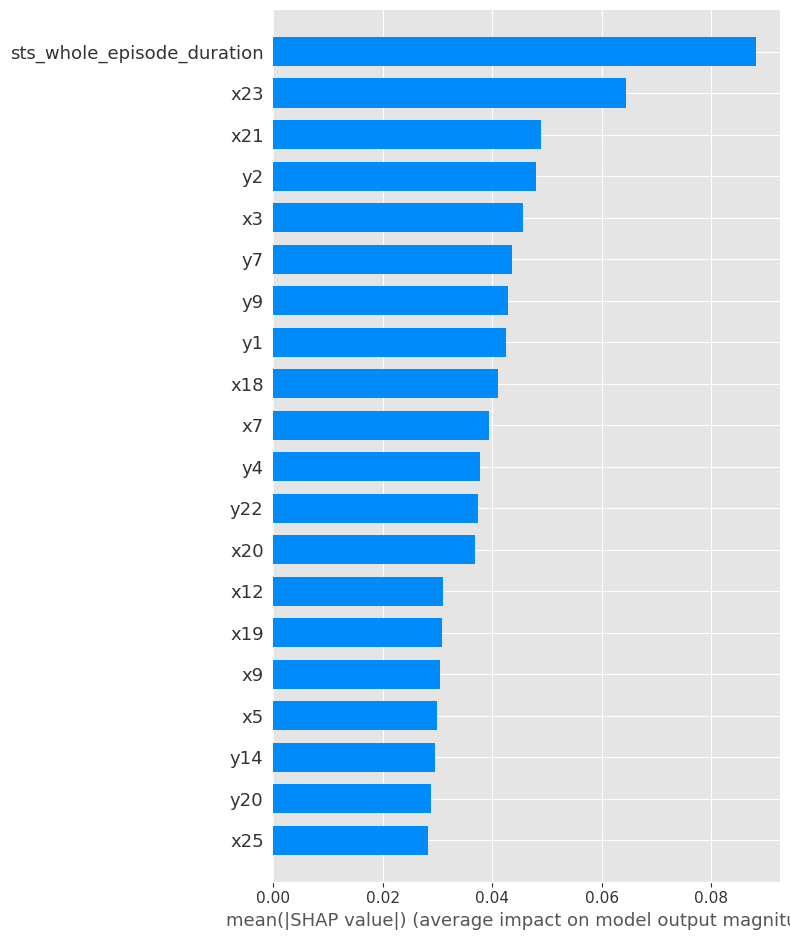

In [18]:
shap_sample = train_data.sample(50, random_state=73)
shap_sample_features = shap_sample[features].values

def model_predict(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float32).to(device) 
    model.eval()
    with torch.no_grad():
        sequences = inputs.view(inputs.shape[0], -1, len(features))
        patient_ids = torch.zeros(inputs.shape[0], dtype=torch.int64).to(device)
        outputs = model(sequences, patient_ids)
        probabilities = nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy()

background = train_data.sample(100)[features].values
explainer = shap.KernelExplainer(model_predict, background)

shap_values = explainer.shap_values(shap_sample_features)

shap_values_class_1 = shap_values[:, :, 1]

shap_values_abs_class_1 = np.abs(shap_values_class_1)

shap.summary_plot(shap_values_abs_class_1, shap_sample_features, feature_names=features, plot_type="bar")

In [19]:
plt.style.use('ggplot')

shap_sample = train_data.sample(1000, random_state=73)
shap_sample_features = shap_sample[features].values

def model_predict(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float32).to(device) 
    model.eval()
    with torch.no_grad():
        sequences = inputs.view(inputs.shape[0], -1, len(features))
        patient_ids = torch.zeros(inputs.shape[0], dtype=torch.int64).to(device)
        outputs = model(sequences, patient_ids)
        probabilities = nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy()

background = train_data.sample(100)[features].values
explainer = shap.KernelExplainer(model_predict, background)

shap_values = explainer.shap_values(shap_sample_features)

shap_values_class_1 = shap_values[:, :, 1]

shap_values_abs_class_1 = np.abs(shap_values_class_1)

plt.figure()

shap.summary_plot(shap_values_abs_class_1, shap_sample_features, feature_names=features, plot_type="bar", show=False)

plt.savefig("shap_summary_bar_plot_sts.png", bbox_inches='tight', dpi=600)

plt.close()

  0%|          | 0/1000 [00:00<?, ?it/s]